In [3]:
#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
import sys
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import cm, colormaps
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, concatenate
from keras.optimizers import Adam
from keras.utils import set_random_seed
import keras
import seaborn as sns
import math
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from work_directory.other_examples.nn_backend.modified_loss_functions import step_msle, exp_msle, sigmoid_msle, cube_msle, linear_msle
from scipy.stats import norm, chisquare
import fast.s26_analysis.utils as utils 
from pathlib import Path

pc=0
#import personal scripts
from nn_backend.import_xyz_img import import_xyz_img
from nn_backend.conv_imgs import conv_imgs

#personalized colormap
viridis = colormaps['viridis']
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 1])
newcolors[0:33, :] = black
newcmp = ListedColormap(newcolors)
del black, newcolors, viridis

In [5]:
#Setup
pc=0


#Constants
pctg=5

curve_height_setpoint=20
curve_nsamples=12

cutout_size=9

#Graphics (1 to show images, 0 to not)
kernel_visualization=0 
input_imgs_view=0

#NN Setup
kernel_dim=3

iterations=300
batch_sz=200
lossf=cube_msle

#Other parameters
name='efm4'
topography_path=rf'c:\Users\mcano\Code\rawdata\img_data\EFM4\Predicted_image_without norm.txt'
ref_path=rf'c:\Users\mcano\Code\rawdata\img_data\EFM4\EFM4 Topography Flattened.txt'
#If using pre-processed curves introduce the path. For raw files set value to 0
curves_file=rf'C:\Users\mcano\Code\rawdata\img_data\EFM4\qi_Zone2_EFM4-data-2020.01.14-15.02.06.545_processed-2020.01.14-16.50.53\processed_curves-2020.01.14-16.50.53'



#Parameters for curve import
calibrate_curves=1
curves_max_limit=1000
img_flip=0 #Used typically with EFM7

m_thresh=0.5


Loading curves…: 100%|███████████████████████| 1/1 [00:00<00:00, 58.85it/s]


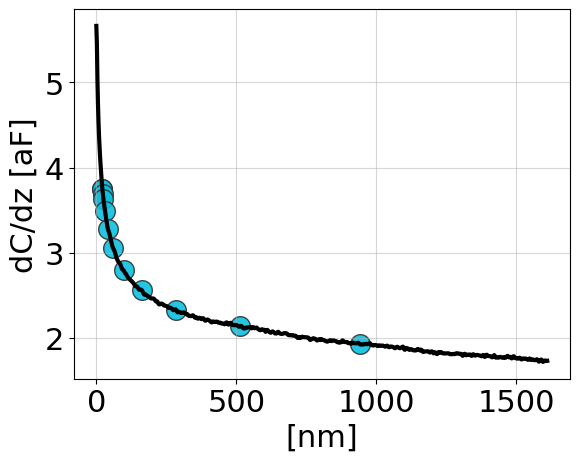

In [54]:
m_vec=[]
zetas=np.arange(curves_max_limit)
curves_nu=np.zeros((1,curves_max_limit))
num=0
last=0

onlyfiles = [f for f in listdir(curves_file) if isfile(join(curves_file, f))]

for i in tqdm(onlyfiles[0:1], 
                desc="Loading curves…", 
                ascii=False, ncols=75):
    file = np.loadtxt(rf'{curves_file}\{i}', comments='#')

    file[:,0] = file[:,0]*1e9

    file=np.flip(file,axis=0)
    
    for n in np.arange(len(file))+1:
        if file[-n,0]<file[-n-1,0]:
            file=file[-n:,:]
            break

    # m=(file[10,1]-file[0,1])/(file[10,0]-file[0,0])
    # m_vec=np.append(m_vec,m)
    # b=file[0,1]-(m*file[0,0])
    # slope=m*file[:,0]+b

    # baseline=np.mean(file[np.round(0.7*len(file)).astype(int):,1])
    # base_std=np.std(file[np.round(0.7*len(file)).astype(int):,1])
    # base_thresh=baseline-2*base_std

    # for k in np.arange(0,len(file)):        
    #     if base_thresh>slope[(k)]:
    #         ZContact=file[(k),0]
    #         break


    # file[:,0]=file[:,0]-ZContact


    arg_maxx=np.argmax(file[:,2])
    maxx_z=file[arg_maxx,0]
    maxx_c=file[arg_maxx,2]
    file=file[arg_maxx:,:]

    # file[:,0]=np.round(file[:,0])
    # file=pd.DataFrame(file)
    # file.drop_duplicates(subset=0,inplace=True)
    # file=np.array(file)
    ccc=file[:,2]
    zzz=file[:,0]-maxx_z
    
    maxlen=1713
    zs=np.logspace(start=0,stop=math.log10(maxlen),num=curve_nsamples,endpoint=False)+curve_height_setpoint
    zs=np.round(zs)
    zs=zs.astype(int)
    samples = []
    [samples.append(x) for x in zs if x not in samples]
    samples=np.array(samples)

    indx_samp= np.array([np.argmin(np.abs(zzz - sample)) for sample in samples])
    plt.scatter(zzz[indx_samp],ccc[indx_samp], s=200, alpha=0.9, facecolors='#0cc0df', edgecolors='#333333')
    plt.plot(zzz,ccc, linewidth=3, color='#000', alpha=1)

    plt.xlabel("[nm]")
    plt.ylabel("dC/dz [aF]")
    plt.rcParams.update({'font.size': 22})
    plt.grid('on', alpha=0.5)
    # plt.xlim([0,1000])
    # projection = np.full((len(zetas)), np.nan)
    # indices = np.where(np.isin(zetas, zzz.astype(int)))[0]
    # cs=ccc[np.isin(np.round(zzz), zetas)]
    # projection[indices] = ccc[np.isin(np.round(zzz), zetas)]
    # projection=np.expand_dims(projection, axis=0)
    # curves_nu=np.concatenate((curves_nu, projection), axis=0)

    # curves_nu=curves_nu[1:,:]
    # curves_nu=pd.DataFrame(curves_nu)
    # curves_nu=curves_nu.interpolate(axis=1)
    # curves_nu=curves_nu.bfill(axis=1)
    # curves_projected=curves_nu
    